In [1]:
!pip install openimages

     |████████████████████████████████| 133kB 28.6MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 7.4MB 43.8MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 144.2MB 95kB/s 
     |████████████████████████████████| 296kB 45.7MB/s 
ERROR: botocore 1.20.49 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [2]:
%mkdir OpenImageDataset

In [3]:
!oi_download_dataset --base_dir /content/OpenImageDataset --labels Tree Skyscraper --format darknet --limit 300 #download the images into OpenImageDataset

tcmalloc: large alloc 1194041344 bytes == 0x55828cfcc000 @  0x7fcaf58481e7 0x558234638f48 0x5582346039c7 0x5582346059c0 0x558234606e8d 0x5582346f899d 0x55823467afe9 0x558234547d14 0x5582346f8ab1 0x558234726799 0x558234676bad 0x558234675b0e 0x55823460902c 0x558234609231 0x5582346781e6 0x558234675b0e 0x55823460902c 0x558234609231 0x5582346781e6 0x558234675b0e 0x558234547e2b 0x5582346781e6 0x558234675b0e 0x55823460877a 0x55823467786a 0x55823460869a 0x558234676a45 0x558234675b0e 0x55823460877a 0x558234676a45 0x558234675b0e
2021-04-10  20:28:30 INFO NumExpr defaulting to 2 threads.
2021-04-10  20:28:33 INFO Downloading 300 train images for class 'tree'
100% 300/300 [00:02<00:00, 127.57it/s]
2021-04-10  20:28:36 INFO Creating 300 train annotations (darknet) for class 'tree'
100% 300/300 [00:00<00:00, 1865.57it/s]
2021-04-10  20:28:40 INFO Downloading 300 train images for class 'skyscraper'
100% 300/300 [00:02<00:00, 113.89it/s]
2021-04-10  20:28:43 INFO Creating 300 train annotations (darkne

In [4]:
%mkdir train #create train directory
%mkdir train/images
%mkdir train/labels
%mv /content/OpenImageDataset/tree/darknet /content/OpenImageDataset/tree/labels #rename the directory 'darknet' to 'labels'
%mv /content/OpenImageDataset/skyscraper/darknet /content/OpenImageDataset/skyscraper/labels

In [5]:
%mkdir valid #create valid directory
%mkdir valid/images
%mkdir valid/labels

In [6]:
import os #for listing directory
import shutil #for moving files
#split dataset into train_set, valid_set (might add test_set later)
def split_datasets(train_set, dir_path):
  image_dir = dir_path + "/images"
  label_dir = dir_path + "/labels"
  imageEntry = os.listdir(image_dir)
  train_count = 0
  for i in imageEntry:
    imageID = i.split(".")[0]
    image_path = image_dir + "/" + imageID + ".jpg"
    label_path = label_dir + "/" + imageID + ".txt"
    if train_count < train_set:
      if not os.path.exists("/content/train/images/" + imageID + ".jpg"): #no duplicates
        shutil.move(image_path, "/content/train/images")
        shutil.move(label_path, "/content/train/labels")
        train_count+=1
      else:
        print("copy train!")
    else:
      if not os.path.exists("/content/valid/images/" + imageID + ".jpg"): #no duplicates
        shutil.move(image_path, "/content/valid/images")
        shutil.move(label_path, "/content/valid/labels")
      else:
        print("copy valid!")

In [7]:
split_datasets(210, '/content/OpenImageDataset/tree') #split datasets
split_datasets(210, '/content/OpenImageDataset/skyscraper') #split datasets

copy train!
copy train!
copy valid!


In [8]:
!git clone https://github.com/ultralytics/yolov5  # clone repo

Cloning into 'yolov5'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 5705 (delta 41), reused 37 (delta 20), pack-reused 5636
Receiving objects: 100% (5705/5705), 8.20 MiB | 35.14 MiB/s, done.
Resolving deltas: 100% (3895/3895), done.


In [10]:
%cd yolov5

/content/yolov5


In [11]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 645kB 19.2MB/s 
Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [12]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [13]:
%%writetemplate /content/data.yaml
train: /content/train/images/
val: /content/valid/images/

nc: 2
names: ['tree', 'skyscraper']

In [15]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml
# parameters
nc: 2  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]


In [16]:
%cd /content/yolov5

/content/yolov5


In [17]:
!python train.py --img 640 --batch 16 --epochs 50 --data '/content/data.yaml' --cfg /content/yolov5/models/custom_yolov5s.yaml --weights yolov5s.pt

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v4.0-192-g0cae757 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=False, cfg='/content/yolov5/models/custom_yolov5s.yaml', data='/content/data.yaml', device='', entity=None, epochs=50, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, weights='yolov5s.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005,

In [19]:
%cd ..
%mkdir treeImageTest

/content


In [20]:
import shutil #moving photos from my phone into some test folder to see how model does
shutil.move("/content/109735225302838614.jpg", "/content/treeImageTest")
shutil.move("/content/3216173965656004335.jpg", "/content/treeImageTest")
shutil.move("/content/4237715337145663000.jpg", "/content/treeImageTest")
shutil.move("/content/5388338697607909698.jpg", "/content/treeImageTest")

'/content/treeImageTest/5388338697607909698.jpg'

In [22]:
%cd yolov5

/content/yolov5


In [23]:
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 640 --conf 0.1 --source /content/treeImageTest

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='/content/treeImageTest', update=False, view_img=False, weights=['/content/yolov5/runs/train/exp/weights/best.pt'])
YOLOv5 🚀 v4.0-192-g0cae757 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 224 layers, 7056607 parameters, 0 gradients, 16.3 GFLOPS
image 1/4 /content/treeImageTest/109735225302838614.jpg: 640x480 5 trees, Done. (0.011s)
image 2/4 /content/treeImageTest/3216173965656004335.jpg: 640x384 3 trees, Done. (0.010s)
image 3/4 /content/treeImageTest/4237715337145663000.jpg: 640x480 9 trees, Done. (0.010s)
image 4/4 /content/treeImageTest/5388338697607909698.jpg: 640x480 1 tree, Done. (0.010s)
Results saved to runs/detect/exp
Done. (0.197s)


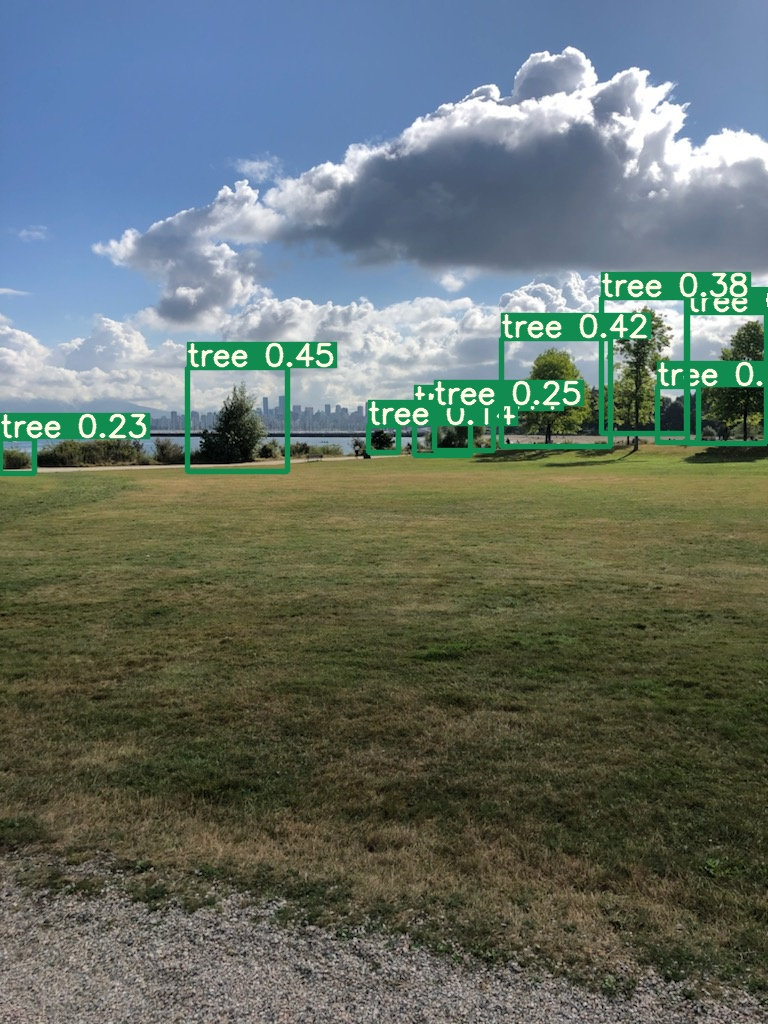

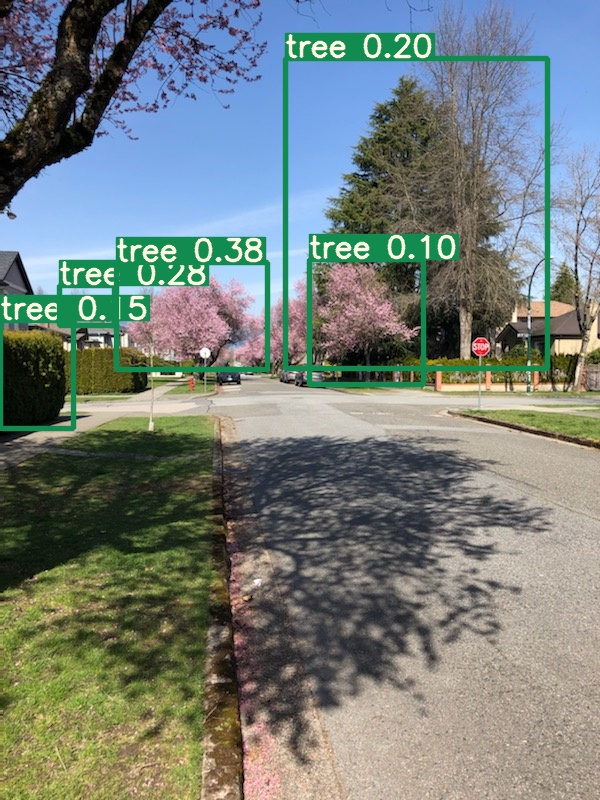

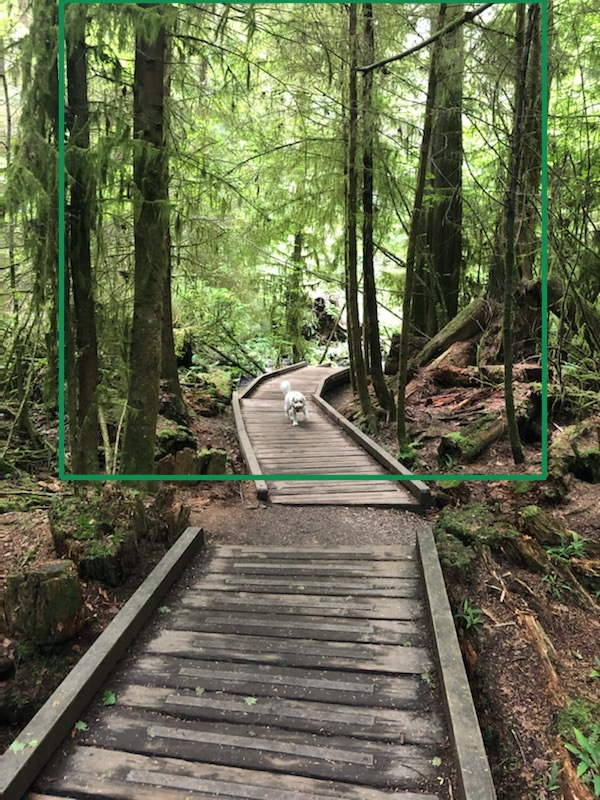

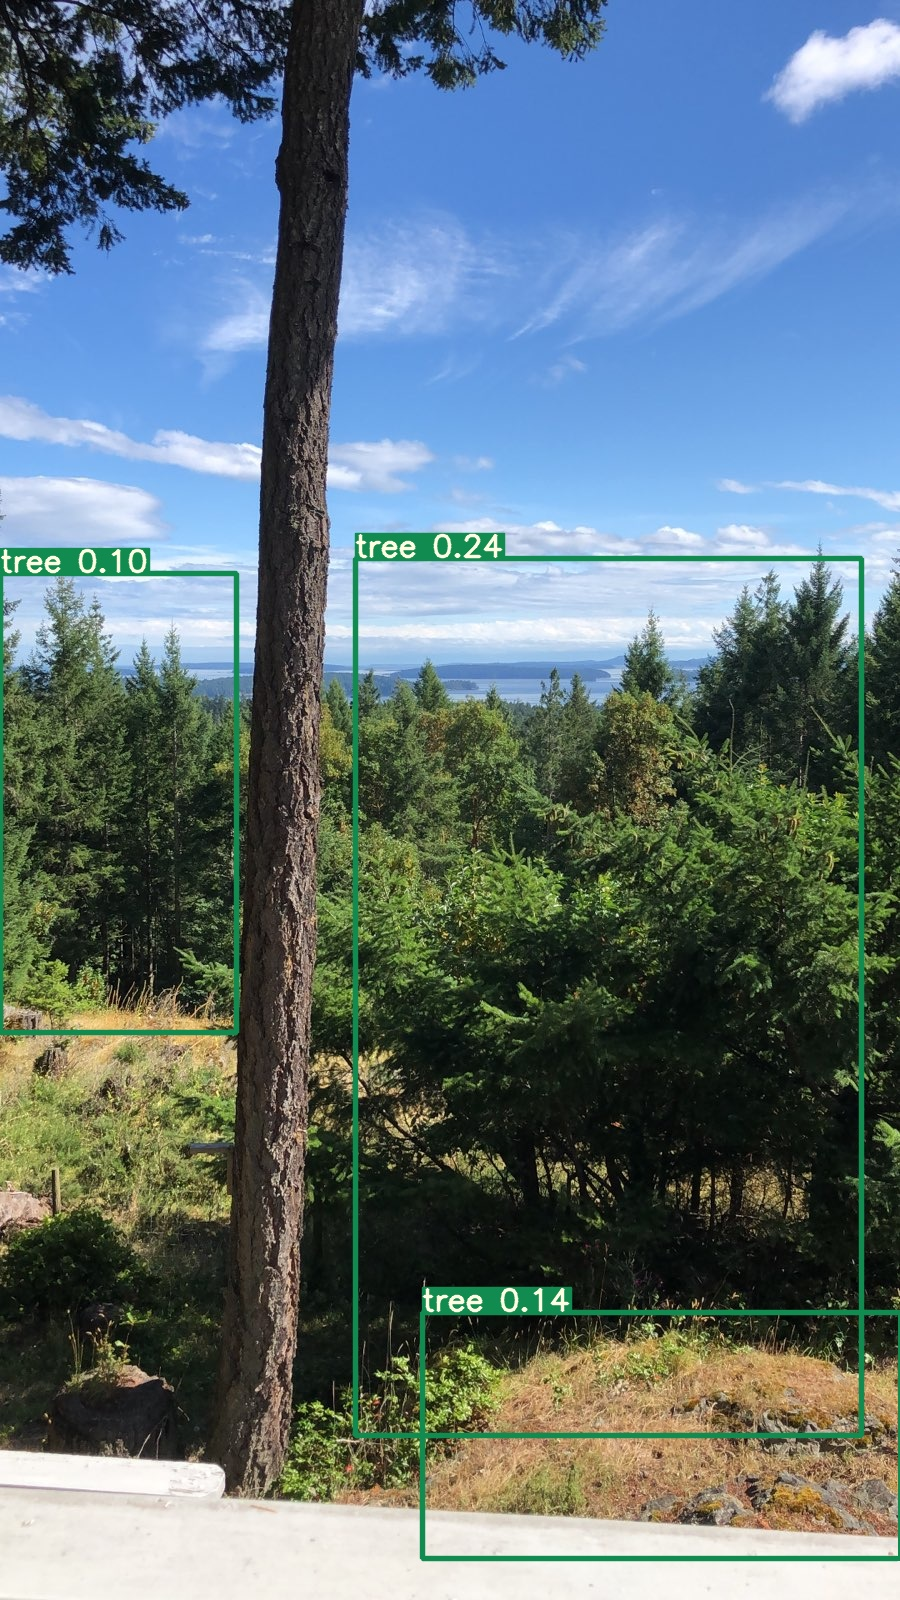

In [24]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

Pretty good bounding box accuracy on some images. But importantly it can detect that there are trees in all the images which is all that we need for the model, since we only be using bounding boxes for faces.

In [25]:
%cd ..
%mkdir skyscraperImageTest

/content


In [26]:
import shutil #moving photos from google images(don't have any skyscraper photos on my phone) into some test folder to see how model does
shutil.move("/content/skyscraper1.jpg", "/content/skyscraperImageTest")
shutil.move("/content/skyscraper2.jpg", "/content/skyscraperImageTest")
shutil.move("/content/skyscraper3.jpg", "/content/skyscraperImageTest")
shutil.move("/content/skyscraper4.jpg", "/content/skyscraperImageTest")

'/content/skyscraperImageTest/skyscraper4.jpg'

In [27]:
%cd yolov5

/content/yolov5


In [28]:
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 640 --conf 0.1 --source /content/skyscraperImageTest

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='/content/skyscraperImageTest', update=False, view_img=False, weights=['/content/yolov5/runs/train/exp/weights/best.pt'])
YOLOv5 🚀 v4.0-192-g0cae757 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 224 layers, 7056607 parameters, 0 gradients, 16.3 GFLOPS
image 1/4 /content/skyscraperImageTest/skyscraper1.jpg: 640x384 3 skyscrapers, Done. (0.011s)
image 2/4 /content/skyscraperImageTest/skyscraper2.jpg: 384x640 1 skyscraper, Done. (0.010s)
image 3/4 /content/skyscraperImageTest/skyscraper3.jpg: 448x640 2 skyscrapers, Done. (0.010s)
image 4/4 /content/skyscraperImageTest/skyscraper4.jpg: 640x448 1 skyscraper, Done. (0.012s)
Results saved to runs/detect/exp2
Done. (0.138s)


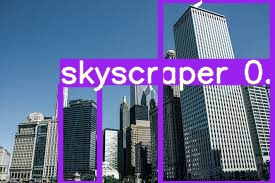

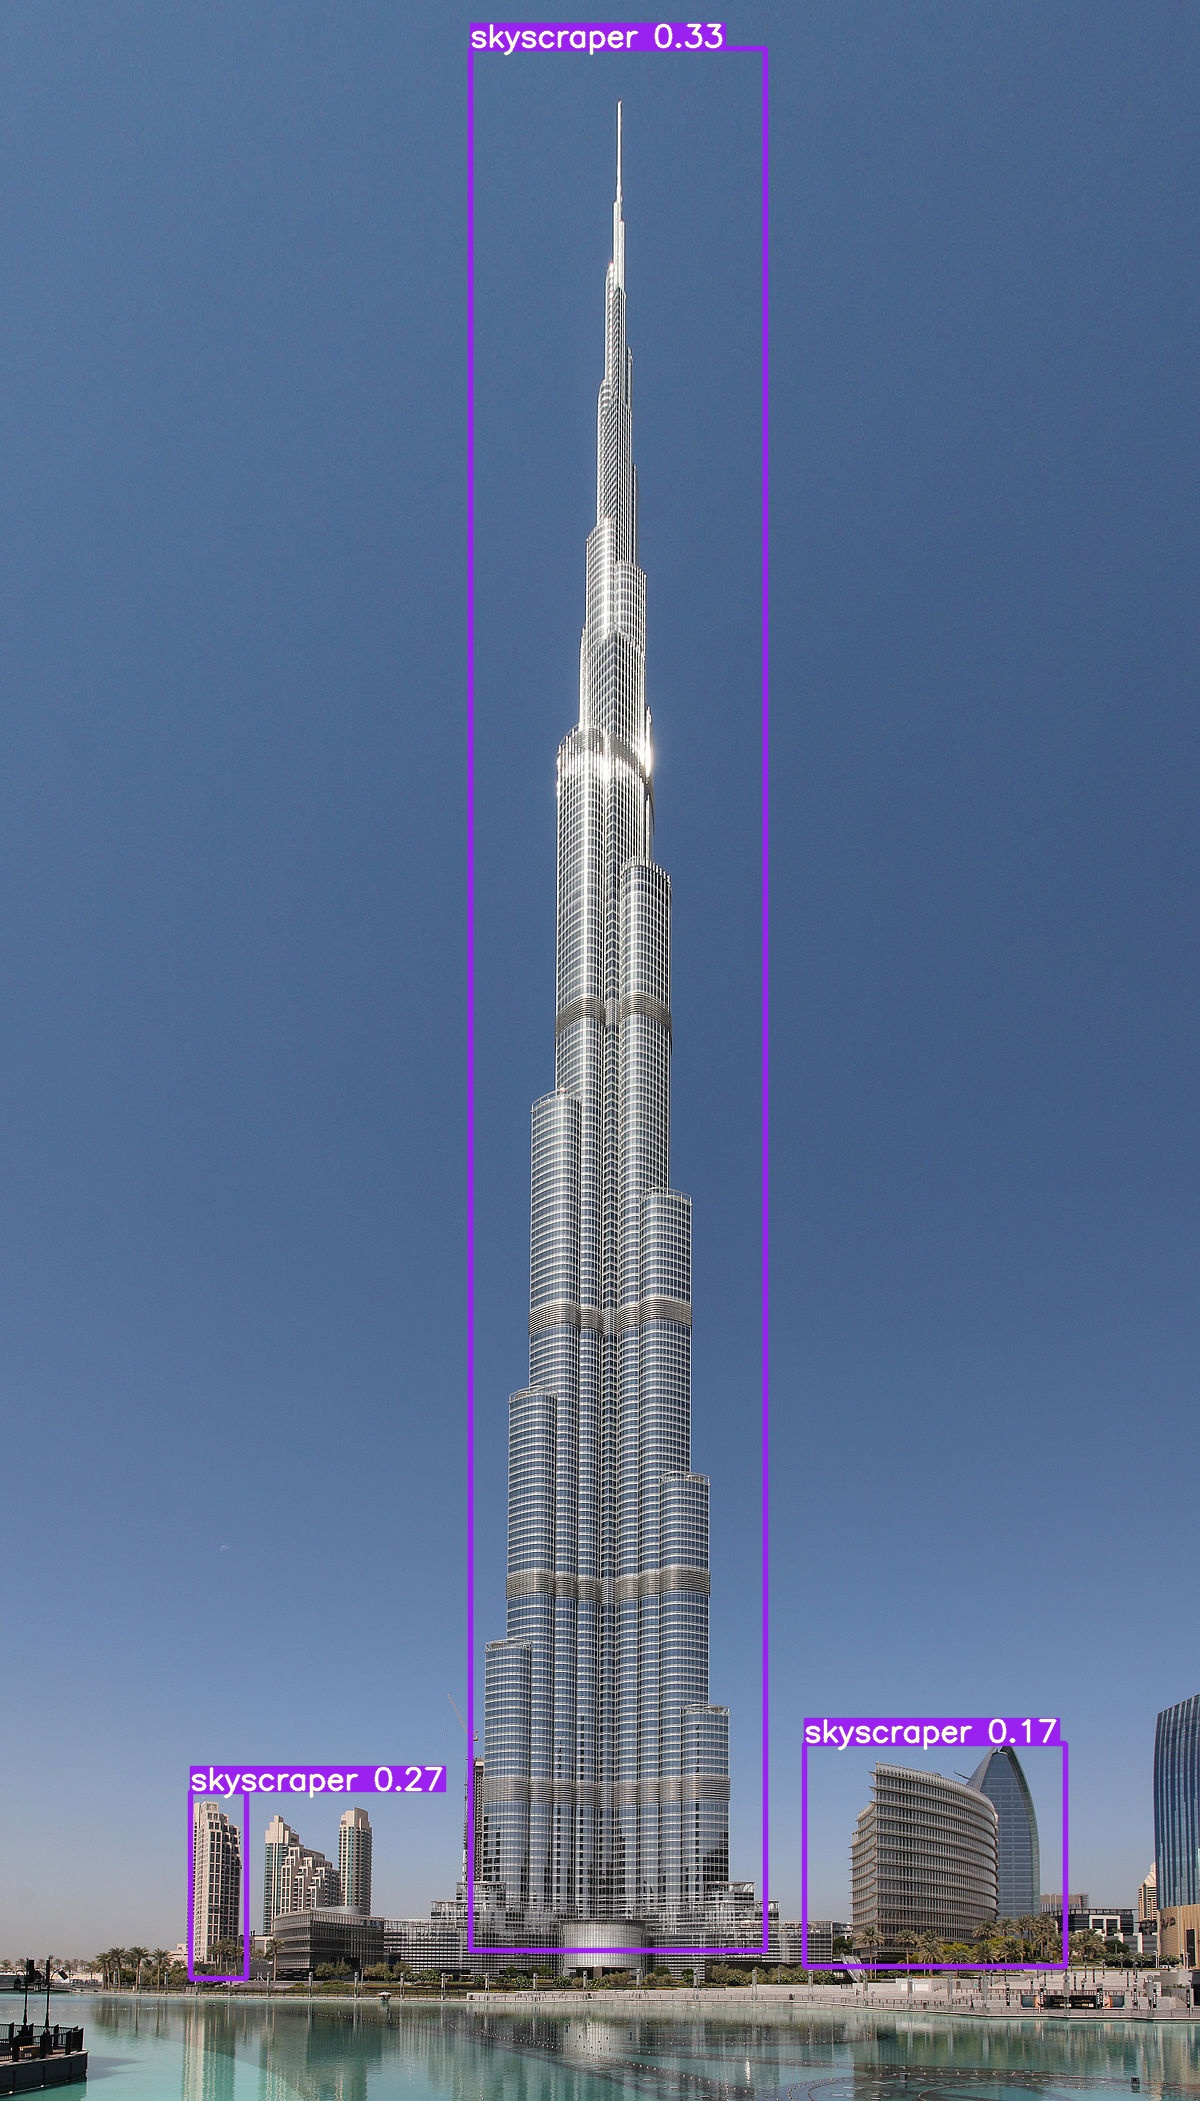

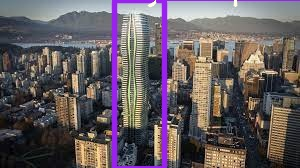

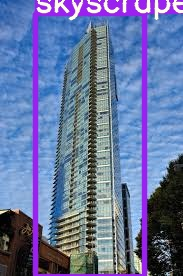

In [29]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

Again pretty good bounding boxes, but as long as the model realizes there are skyscrapers in the model then it is good.

In [36]:
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 640 --conf 0.01 --source /content/skyscrapertree.jpg

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.01, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='/content/skyscrapertree.jpg', update=False, view_img=False, weights=['/content/yolov5/runs/train/exp/weights/best.pt'])
YOLOv5 🚀 v4.0-192-g0cae757 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 224 layers, 7056607 parameters, 0 gradients, 16.3 GFLOPS
image 1/1 /content/skyscrapertree.jpg: 480x640 4 trees, 6 skyscrapers, Done. (0.011s)
Results saved to runs/detect/exp6
Done. (0.031s)


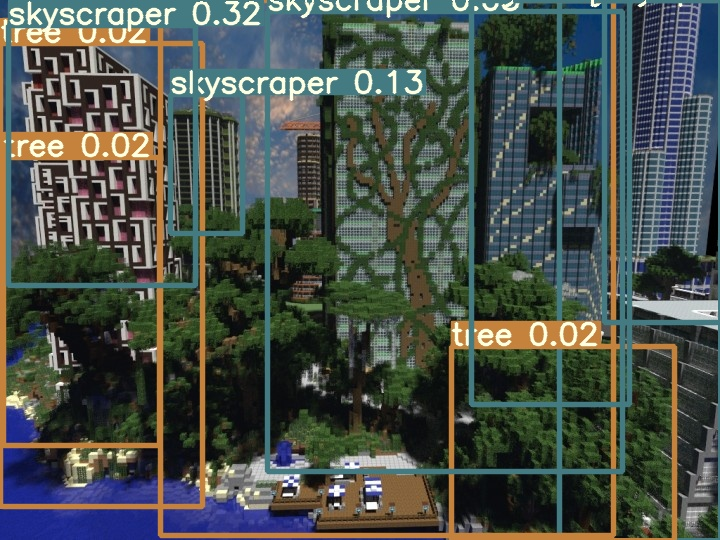

In [37]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp6/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

For fun I tried an image from minecraft which has trees and skyscrapers. This did not perform as well as others for obvious reasons but it can still predict some objects if you set the confidence level low enough.

In [39]:
%cd ..
%mkdir randomTest

/content


In [40]:
import shutil #moving random photos from google images. the model should not detect anything on these
shutil.move("/content/randomimage1.jpg", "/content/randomTest")
shutil.move("/content/randomimage2.jpg", "/content/randomTest")
shutil.move("/content/randomimage3.jpg", "/content/randomTest")
shutil.move("/content/randomimage4.jpg", "/content/randomTest")

'/content/randomTest/randomimage4.jpg'

In [42]:
%cd yolov5

/content/yolov5


In [43]:
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 640 --conf 0.1 --source /content/randomTest

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='/content/randomTest', update=False, view_img=False, weights=['/content/yolov5/runs/train/exp/weights/best.pt'])
YOLOv5 🚀 v4.0-192-g0cae757 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 224 layers, 7056607 parameters, 0 gradients, 16.3 GFLOPS
image 1/4 /content/randomTest/randomimage1.jpg: 352x640 1 tree, Done. (0.010s)
image 2/4 /content/randomTest/randomimage2.jpg: 448x640 Done. (0.011s)
image 3/4 /content/randomTest/randomimage3.jpg: 224x640 Done. (0.008s)
image 4/4 /content/randomTest/randomimage4.jpg: 288x640 Done. (0.009s)
Results saved to runs/detect/exp7
Done. (0.061s)


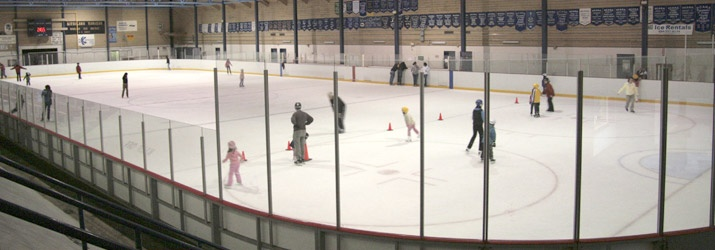

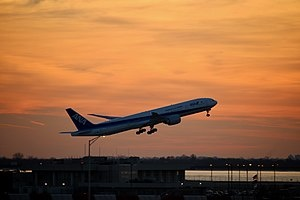

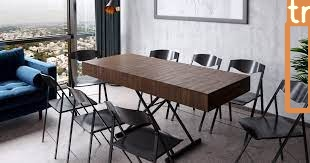

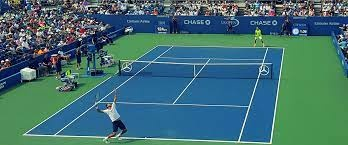

In [44]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp7/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

Model did not detect anything except in the third image where it detects a tree. This makes sense though as there does seem to be a potted plant there which I did not even see.